### Импортируем библиотеки

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import average_precision_score, precision_recall_curve

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import ClusterCentroids, TomekLinks


In [2]:
RANDOM_SEED = 42

In [3]:
import warnings
warnings.filterwarnings("ignore")

Создадим функции для удобной оценки признаков и модели

In [4]:
# статистические данные по выбросам
def statistic(col):
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l = perc25 - 1.5*IQR
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col, IQR),
          "Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(
        df[df[col] > r][col].count()+df[df[col] < l][col].count()))

In [5]:
# Таблица метрик для сравнения результатов каждой модели
metr_list = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']
all_models = pd.DataFrame(metr_list, columns=['Metrics'])

def cumulated_metr(data, col, y_test, y_pred, probs):
    model_metr = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(
        y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, probs)]
    temp_cum_df = pd.DataFrame(model_metr, columns=[col])
    data = data.join(temp_cum_df,  how='left')
    return data

In [6]:
# создадим функцию регуляризации
def regularise(X_train, y_train):
    C = np.logspace(0, 4, 10)
    penalty = ['l1', 'l2']
    hyperparameters = dict(C=C, penalty=penalty)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters, cv=4, verbose=0)

    best_model = clf.fit(X_train, y_train)

    best_penalty = best_model.best_estimator_.get_params()['penalty']
    best_c = best_model.best_estimator_.get_params()['C']
    best_solver = best_model.best_estimator_.get_params()['solver']
    return best_penalty, best_c, best_solver

In [7]:
# функция обучения модели
def new_model(best_penalty, best_c, X_train, y_train, weight=None):
    lgr = LogisticRegression(penalty=best_penalty, C=best_c, class_weight=weight)
    lgr.fit(X_train, y_train)
    y_pred = lgr.predict(X_test)
    probs = lgr.predict_proba(X_test)
    probs = probs[:, 1]
    return lgr, y_pred, probs

In [8]:
# таблица метрик модели
def get_metrics(y_test, y_pred, probs):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metrics = {}
    P = np.sum(y_test == 1)
    N = np.sum(y_test == 0)
    TP = np.sum((y_test == 1) & (y_pred == 1))
    TN = np.sum((y_test == 0) & (y_pred == 0))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    FN = np.sum((y_test == 1) & (y_pred == 0))

    dict_metrics['P'] = ['Positive', P, 'Дефолт']
    dict_metrics['N'] = ['Negative', N, 'Без дефолта']
    dict_metrics['TP'] = ['True positive', TP, 'Истинно дефолтные']
    dict_metrics['TN'] = ['True Negative', TN, 'Истинно НЕ дефолтные']
    dict_metrics['FP'] = ['False Positive', FP, 'Ложно дефолтные']
    dict_metrics['FN'] = ['False Negative', FN, 'Ложно НЕ дефолтные']
    dict_metrics['Accuracy'] = ['Accuracy', accuracy_score(
        y_test, y_pred), 'Accuracy=(TP+TN)/(TP+TN+FP+FN)']
    dict_metrics['Precision'] = ['Precision', precision_score(
        y_test, y_pred), 'Точность = TP/(TP+FP)']
    dict_metrics['Recall'] = ['Recall', recall_score(
        y_test, y_pred), 'Полнота = TP/(TP+FN)']
    dict_metrics['F1-score'] = ['F-мера',
                                f1_score(y_test, y_pred), 'Среднее гармоническое Precision и Recall']
    dict_metrics['ROC_AUC'] = ['ROC_AUC',
                               roc_auc_score(y_test, probs), 'ROC-AUC']

    temp_df = pd.DataFrame.from_dict(dict_metrics, orient='index', columns=[
                                     'Metrics', 'Result', 'Description'])
    display(temp_df)

# таблица confusion matrix
def conf_matrix(y_test, y_pred):
    data = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[
        ['Default', 'Non default']], columns=[['Default', 'Non default']]).astype(str)
    data.iloc[0, 0] = "TP: " + data.iloc[0, 0]
    data.iloc[0, 1] = "FP: " + data.iloc[0, 1]
    data.iloc[1, 0] = "FN: " + data.iloc[1, 0]
    data.iloc[1, 1] = "TN: " + data.iloc[1, 1]
    display(data)

# кривая ROC_AUC
def roc_curv(y_test, probs):
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label='Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' %
              roc_auc_score(y_test, probs))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# график Precision_recall
def recall_precision_plot(y_test, y_pred):
    precisions, recalls, thereshold = precision_recall_curve(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred)
    plt.figure()
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
    plt.grid(True)
    plt.show()

In [9]:
train = pd.read_csv(r'C:\Python\Credit\train.csv')
test= pd.read_csv(r'C:\Python\Credit\test.csv')



Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [10]:
# добавим признак, чтобы было можно определить из какого датасета наблюдение
train["is_test"] = False
test["is_test"] = True

# т.к. в тестовом датасете нет целевого признака, добавим его и заполним нулями
test["default"] = 0

# объединим оба датасета в один для удобства построения графиков и заполнения пропусков
df = pd.concat([train, test], ignore_index=True)
  

In [11]:
df.head(1)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,is_test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,False


Получим информацию о датасетах

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Датасет содержит 12 признаков в виде чисел и 6 признаков в виде строк. Пропуски содержит только признак education. Для наглядности посмотрим на данный признак на графике.

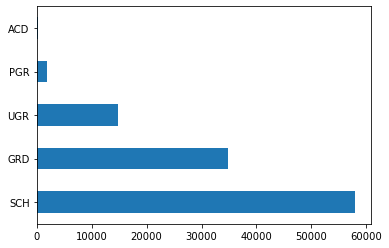

In [13]:
df['education'].value_counts().plot.barh()

In [14]:
# заполним пропуски значением, которое встречается чаще всего
df["education"].fillna(df[~df["is_test"]]["education"].mode()[0], inplace=True)

In [15]:
# проверим успешность заполнения
df.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
is_test             0
dtype: int64

In [16]:
# определим, какие признаки являются числовыми, какие - категориальные, и какие - бинарные
df.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
is_test                  2
dtype: int64

In [17]:
# признаки с большим количеством уникальных значений отнесем к числовым, за исключением app_date,
# так как он содержит дату в виде строки.
# Также не будем использовать признак client_id, так как все его значения уникальны
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income"]

# к бинарным отнесем остальные признаки, количество уникальных значений которых равно 2
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# все остальные - категориальные
cat_cols = ["education", "region_rating", "home_address", "work_address", "sna", "first_time"]

Сконветируем формат даты к удобному для работы

In [18]:
# сконветируем формат даты к удобному для работы
df.app_date = pd.to_datetime(df.app_date)
print(df.app_date.head(1))

0   2014-02-01
Name: app_date, dtype: datetime64[ns]


In [19]:
# на основе признака app_date создадим новые признаки
df['app_day'] = df.app_date.dt.day
df['app_month'] = df.app_date.dt.month
df['app_year'] = df.app_date.dt.year
df["app_weekday"] = df["app_date"].dt.weekday

In [20]:
print(df.app_year.unique())
# в нашем датасете присутствуют только записи, где год подачи заявки - 2014
# добавим новый признак, обозначающий количество дней прошедших с начала 2014 года
df["app_passed_days"] = (df["app_date"] - datetime(2014, 1, 1)).dt.days

[2014]


Удалим признак app_year, потому что у него одно уникальное значение. app_date нам также не нужен, так как вся содержащаяся в нем информация уже есть в других признаках.



In [21]:
df.drop(["app_date", "app_year"], axis=1, inplace=True)

In [22]:
# распределим новые признаки к числовым переменным
num_cols.extend(["app_day", "app_month", "app_weekday", "app_passed_days"])

## Визуализация

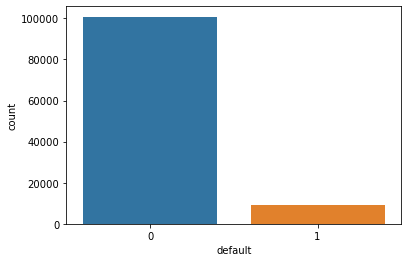

In [23]:
# распределение целеой переменной
sns.countplot(df['default'])

In [24]:
df['default'].value_counts()

0    100776
1      9372
Name: default, dtype: int64

Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

Построим графики распределения численных переменных

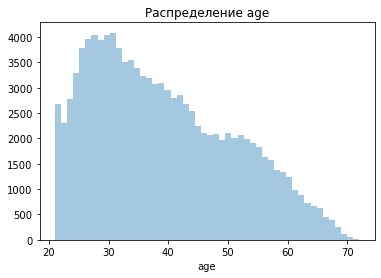

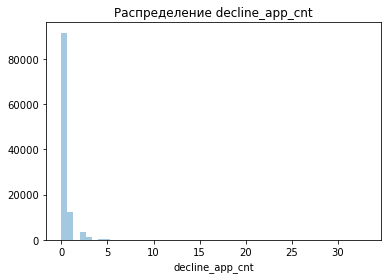

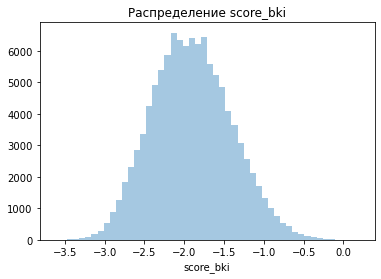

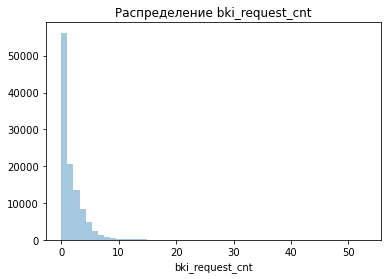

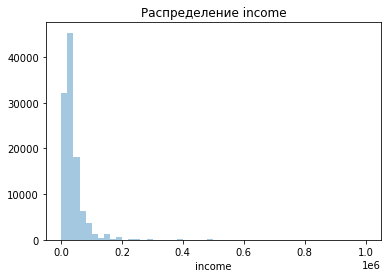

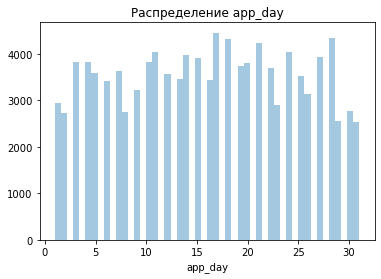

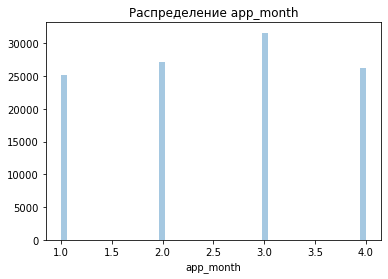

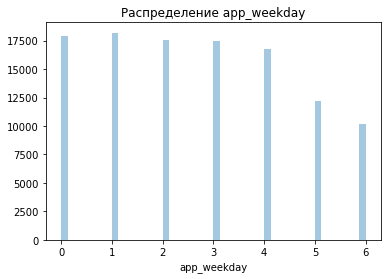

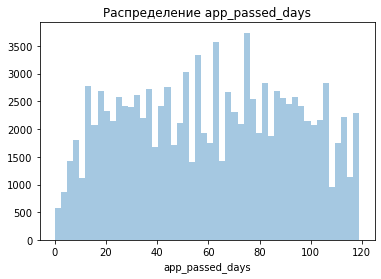

In [25]:
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(df[col], kde=False)

In [26]:
df[num_cols].describe()

,age,decline_app_cnt,score_bki,bki_request_cnt,income,app_day,app_month,app_weekday,app_passed_days
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,39.249410,0.273205,-1.904535,2.005002,41012.648537,15.959100,2.535107,2.674157,60.971466
std,11.518063,0.799099,0.499397,2.266926,45399.735051,8.598467,1.087680,1.896814,32.076078
min,21.000000,0.000000,-3.624586,0.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,30.000000,0.000000,-2.260434,0.000000,20000.000000,9.000000,2.000000,1.000000,33.000000
50%,37.000000,0.000000,-1.920823,1.000000,30000.000000,16.000000,3.000000,3.000000,62.000000
75%,48.000000,0.000000,-1.567888,3.000000,48000.000000,23.000000,3.000000,4.000000,89.000000
max,72.000000,33.000000,0.199773,53.000000,1000000.000000,31.000000,4.000000,6.000000,119.000000


Выводы по числовым признакам:

- age: график распределения возраста смещен вправо, возраст имеет значения от 21 года до 72 лет и медианой 37 лет
- decline_app_cnt (количество отказанных прошлых заявок): распределение также смещено вправо, большинству клиентов (более 75%) раньше не отказывали в кредите, есть небольшое количество клиентов, кому отказывали много раз, максимальный результат - 33 раза. Я не считаю это выброс, т.к. такая ситуация возможна
- score_bki (скоринговый балл): cкоринговый балл в среднем выше у дефолтных клиентов
- bki_request_cnt (количество запросов в БКИ): распределение признака сильно смещено вправо, более 75% клиентов имеют значение менее 3 запросов, но есть те, у кого количество запросов достигает больших значений. Максимум - 53 запроса. Это также не похоже на нереальный результат.
- income: доход клиентов варьируется от 1000 до 1000000 с медианным показателем 30000
- app_day, app_weekday, app_month: принимают значения от 1 до 31, от 0 до 7 и от 1 до 4 соответственно
- app_passed_days (количество дней с начала 2014 до даты подачи заявки): в нашем датасете находятся данные только за первые 4 месяца 2014 года, количество заявок по дням примерно равномерное за исключением начала и окончания периода. В начале и конце периода заявок несколько меньше.

In [27]:
# обратим значения скорингового балла
df['score_bki'] = df['score_bki'] + abs(df['score_bki'].min())

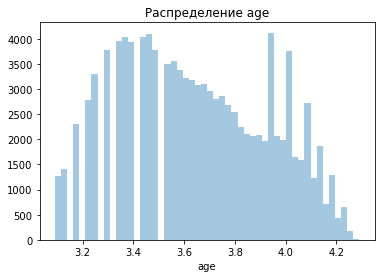

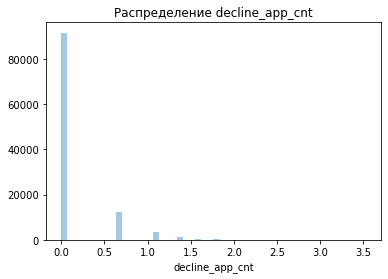

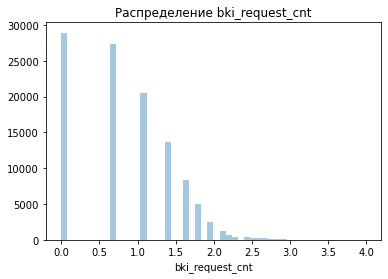

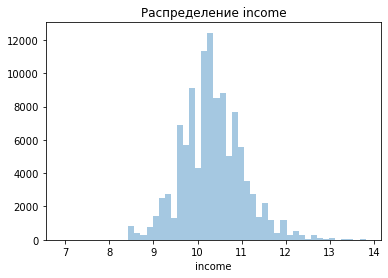

In [28]:
# признаки, которые имеют ярко выраженное смещение вправо, мы логарифмируем, для того,
# чтобы распределение было больше похоже на нормальное, остальные оставим как есть
# и посмотрим на распределение
shifted_features = ["age", "decline_app_cnt", "bki_request_cnt", "income"]
df[shifted_features] = np.log(df[shifted_features] + 1)
for col in shifted_features:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(df[col], kde=False)

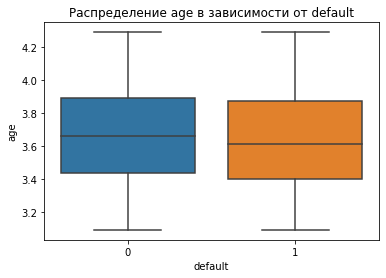

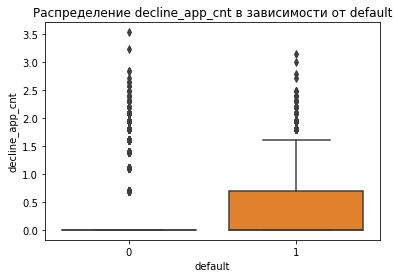

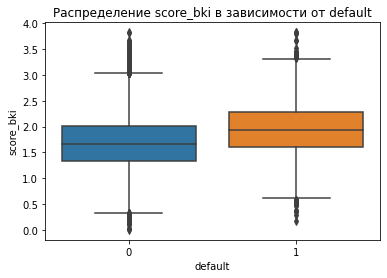

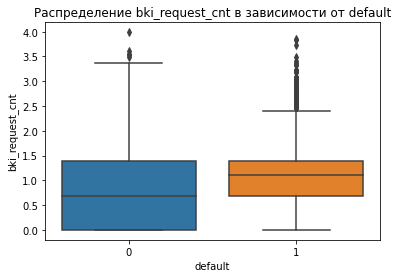

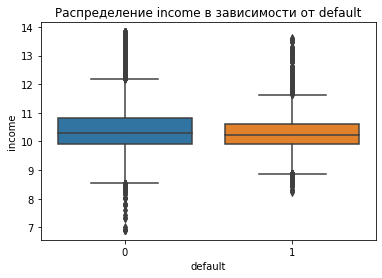

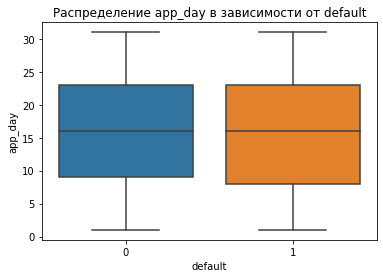

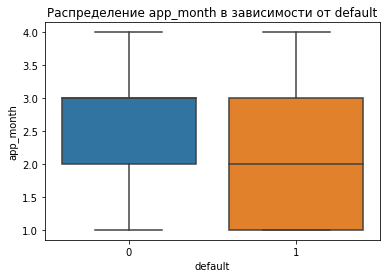

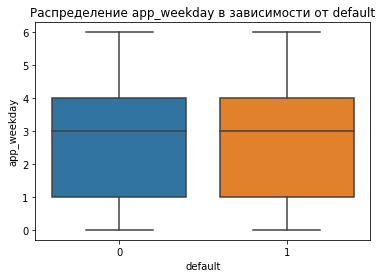

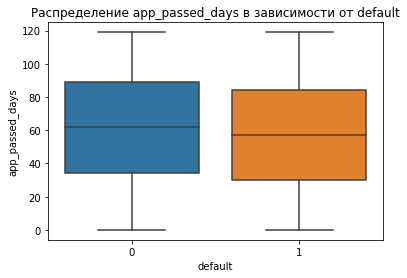

In [29]:
# посмотрим на распределение числовых признаков в зависимости от целевого признака
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col} в зависимости от default")
    sns.boxplot("default", col, data=df[~df["is_test"]])

Судя по графикам, возраст, день подачи заявки и день недели подачи заявки практически не оказывает влияния на вероятность дефолта.

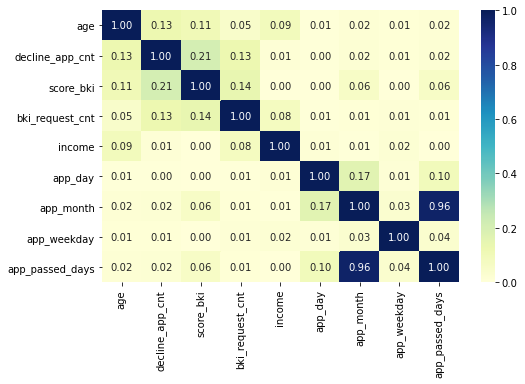

In [30]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1,
            annot=True, fmt=".2f", cmap="YlGnBu")

Видна большая корреляция app_passed_days и app_month, посмотрим значимость числовых признаков и уберем менее значимый.

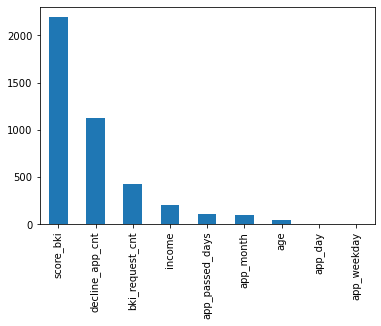

In [31]:
# используем дисперсионный анализ ANOVA для определения значимости наших числовых признаков
imp_num = pd.Series(f_classif(df[num_cols], df["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")

Наибольшее влияние на вероятность дефолта имеет скоринговый балл, очень маленькое влияние - день подачи заявки и день недели подачи заявки. Удалим их и месяц подачи заявки

In [32]:
num_cols = [col for col in num_cols if col not in ["app_day", "app_weekday", "app_month"]]
df.drop(["app_day", "app_weekday", "app_month"], axis=1, inplace=True)

## Преобразование бинарных и категориальных переменных

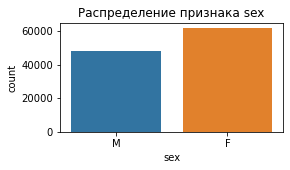

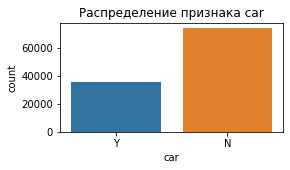

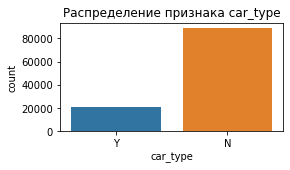

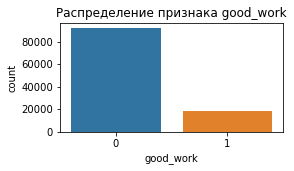

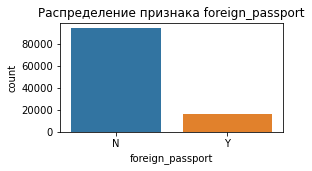

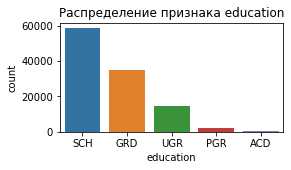

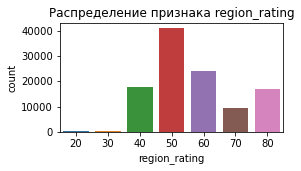

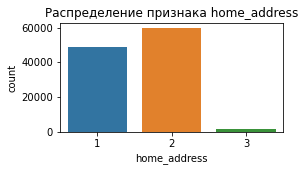

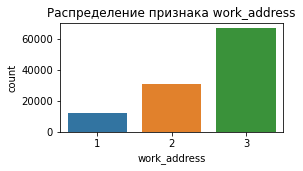

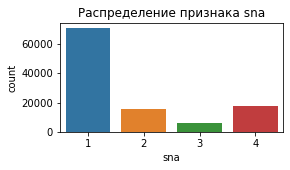

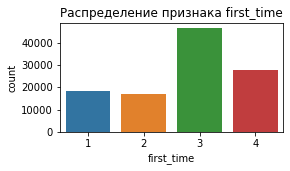

In [33]:
# посмотрим распределение категориальных и бинарных признаков
for col in bin_cols + cat_cols:
    plt.figure(figsize=(4, 2))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

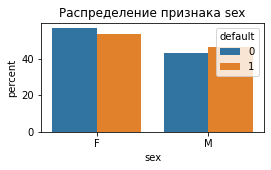

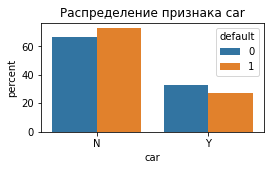

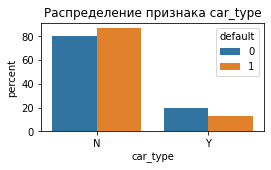

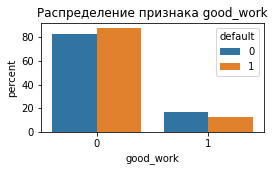

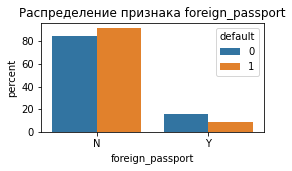

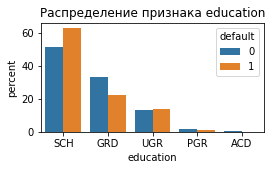

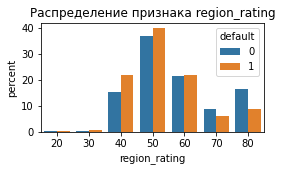

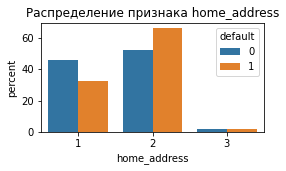

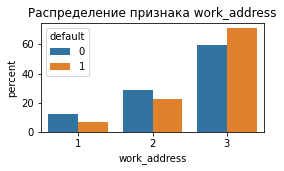

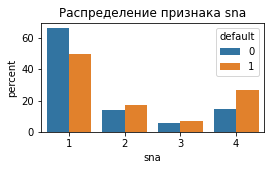

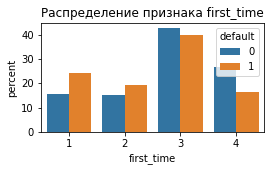

In [34]:
# теперь посмотрим распределение категориальных и бинарных признаков в зависимости от целевого признака
# графики показывают относительное распределение признаков по каждой группе клиентов: "хороших" и "плохих"
data = df[~df["is_test"]]
for col in bin_cols + cat_cols:
    plt.figure(figsize=(4, 2))
    prop_df = data[col].groupby(data["default"]).value_counts(
        normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

Выводы по категориальным признакам:
- sex: женщин в выборке немного больше, чем мужчин; женщины более часто отдают кредит, чем мужчины, но разница незначительна
- car: клиентов с машиной примерно в 2 раза меньше, чем без машины. Те, у кого есть машина, более кредитоспособны
- car_type: клиентов, у которой машина иномарка, еще меньше, и они также более кредитоспособны. Судя по графикам, именно наличие иномарки влияет на кредитоспособность клиента. Чуть позже создадим новый признак, наличие отечественной машины, чтобы проверить предположение
- good_work: клиентов с хорошей работой значительно меньше, чем остальных и они более кредитоспособны
- foreign_passport: клиентов с загранпаспортом также значительно меньше остальных и они тоже более кредитоспособны
- education: чем выше уровень образования у клиента, тем выше вероятность вернуть кредит
- home_address: домашние адреса распределены по 3 категориям. Клиенты, проживающие в 1 категории адреса более кредитоспособны, чем во второй и в третьей
- work_address: рабочие адреса также распределены по 3 категориям. Клиенты, работающие в 1 и 2 категориях адреса более кредитоспособны, чем работающие в 3 категории
- sna (связь заемщика с клиентами банка): чем выше показатель, тем выше риск невозврата кредита
- region_score: ординальный признак, принимающий значение от 20 до 80 с шагом 10
- first_time (давность наличия информациии о заемщике): чем выше показатель, тем более благонадежен клиент

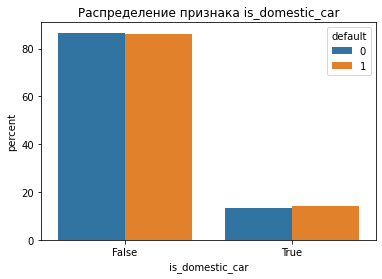

In [35]:
# создадим признак, показывающий наличие отечественной машины и посмотрим, оказывает ли он влияние на вероятность дефолта
df["is_domestic_car"] = (df["car"] == "Y") & (df["car_type"] == "N")

plt.figure()
prop_df = df["is_domestic_car"].groupby(df["default"]).value_counts(
    normalize=True).rename("percent").reset_index()
prop_df["percent"] *= 100
sns.barplot(x="is_domestic_car", y="percent", hue="default", data=prop_df)
plt.title("Распределение признака is_domestic_car")
plt.show()

Похоже только наличие иномарки является положительным фактором для принятия решения о выдаче кредита. Так как наличие машины само по себе не влияет на вероятность дефолта, удалим признак car из датасета. Новый признак нам также не нужен, так как он не оказывает никакого влияния на целевую переменную

In [36]:
bin_cols.remove("car")
df.drop(["car", "is_domestic_car"], axis=1, inplace=True)

Чтобы определить значимость категориальных и бинарных признаков для модели, нужно перекодировать их в числа.

In [37]:
# перекодируем значения бинарных признаков в 0 или 1
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [38]:
# образование и рейтинг региона - это ординальные признаки, поэтому нужно перекодировать их значения так,
# чтобы значения возрастали при увеличении уровня образования; для образования: от 0 - школа, до 4 - академик
grade = ["SCH", "UGR", "GRD", "PGR", "ACD"]
df["education"] = OrdinalEncoder(categories=[grade]).fit_transform(
    df[["education"]]).astype(int)
rating = [20, 30, 40, 50, 60, 70, 80]
df["region_rating"] = OrdinalEncoder(categories=[rating]).fit_transform(
    df[["region_rating"]]).astype(int)

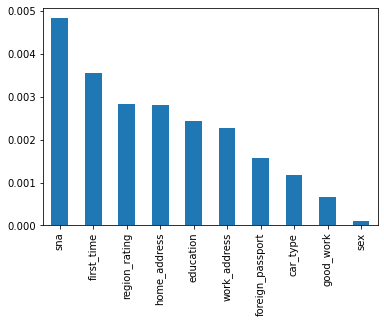

In [39]:
# определим значимость категориальных и бинарных признаков
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df["default"],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True, ascending=False)
imp_cat.plot(kind="bar")

Исходя из данных графика можно сделать вывод о малозначимости признака sex. А также мы можем увидеть высокую значимость признаков: связь заемщика с клиентами банка и давности наличия информации о заемщике, а также
различных степеней образования на наш результат.

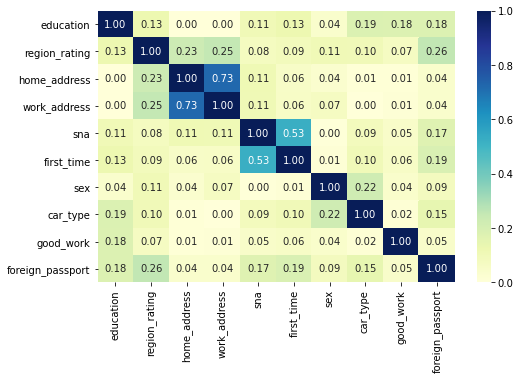

In [40]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(df[cat_cols+bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", cmap="YlGnBu")

Наблюдается значительная взаимосвязь между местом работы и проживания

## Подготовка данных к машинному обучению

In [41]:
# добавим новые признаки, которые являются комбинациями числовых признаков
poly = PolynomialFeatures(2, include_bias=False)
poly_data = poly.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = poly.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df,  how='left')

In [42]:
df = pd.get_dummies(
    df, columns=['home_address', 'work_address', 'sna', 'first_time'], dummy_na=False)

In [43]:
# вновь разобьем выборку на тренировочную и тестовую
train = df[~df["is_test"]].drop("is_test", axis=1)
test = df[df["is_test"]].drop("is_test", axis=1)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [44]:
id_test = test.client_id
Y = train['default'].values
train.drop(["client_id", "default"], axis=1, inplace=True)
test.drop(["client_id", "default"], axis=1, inplace=True)
X = train.values
test = test.values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42, shuffle=True)

## Регуляризация

In [46]:
best_penalty, best_c, best_solver = regularise(X_train, y_train)
best_penalty, best_c, best_solver

('l2', 10000.0, 'lbfgs')

Обучим модель

In [47]:
# создадим модель без учета несбалансированности данных
best_penalty, best_c, best_solver = regularise(X_train, y_train)
lgr_no_sampling, y_pred_no, no_probs = new_model(best_penalty, best_c, X_train, y_train)
all_models = cumulated_metr(all_models, 'lgr_no_sampling', y_test, y_pred_no, no_probs)

In [48]:
# создадим модель с учетом несбалансированности
lgr_w, y_pred_w, w_probs = new_model(best_penalty, best_c, X_train, y_train, weight='balanced')
all_models = cumulated_metr(all_models, 'lgr_w', y_test, y_pred_w, w_probs)

Далее я пробую модели обученные с различными видами over и under sampling

In [49]:
X_sm, y_sm = SMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)
best_penalty, best_c, best_solver = regularise(X_sm, y_sm)
lgr_sm, y_pred_sm, sm_probs = new_model(best_penalty, best_c, X_sm, y_sm)
all_models = cumulated_metr(all_models, 'lgr_sm', y_test, y_pred_sm, sm_probs)

In [51]:
X_tl, y_tl = TomekLinks().fit_resample(X_train, y_train)
best_penalty, best_c, best_solver = regularise(X_tl, y_tl)
lgr_tl, y_pred_tl, tl_probs = new_model(best_penalty, best_c, X_tl, y_tl)
all_models = cumulated_metr(all_models, 'lgr_tl', y_test, y_pred_tl, tl_probs)

In [52]:
X_bsm, y_bsm = BorderlineSMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)
best_penalty, best_c, best_solver = regularise(X_bsm, y_bsm)
lgr_bsm, y_pred_bsm, bsm_probs = new_model(best_penalty, best_c, X_bsm, y_bsm)
all_models = cumulated_metr(all_models, 'lgr_bsm', y_test, y_pred_bsm, bsm_probs)

In [53]:
X_ad, y_ad = ADASYN().fit_resample(X_train, y_train)
best_penalty, best_c, best_solver = regularise(X_ad, y_ad)
lgr_ad, y_pred_ad, ad_probs = new_model(best_penalty, best_c, X_ad, y_ad)
all_models = cumulated_metr(all_models, 'lgr_ad', y_test, y_pred_ad, ad_probs)

In [54]:
X_os, y_os = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
best_penalty, best_c, best_solver = regularise(X_os, y_os)
lgr_os, y_pred_os, os_probs = new_model(best_penalty, best_c, X_os, y_os)
all_models = cumulated_metr(all_models, 'lgr_os', y_test, y_pred_os, os_probs)

Также попробуем подобрать оптимальную модель при помощи LogisticRegressionCV

In [55]:
lgr_cv = LogisticRegressionCV(
    cv=5, class_weight='balanced', scoring = 'balanced_accuracy', max_iter=100, random_state=42).fit(X_train, y_train)

In [56]:
y_pred_cv = lgr_cv.predict(X_test)
probs_cv = lgr_cv.predict_proba(X_test)
probs_cv = probs_cv[:, 1]

In [57]:
get_metrics(y_test, y_pred_cv, probs_cv)

,Metrics,Result,Description
P,Positive,1827.000000,Дефолт
N,Negative,12933.000000,Без дефолта
TP,True positive,1230.000000,Истинно дефолтные
TN,True Negative,8640.000000,Истинно НЕ дефолтные
FP,False Positive,4293.000000,Ложно дефолтные
FN,False Negative,597.000000,Ложно НЕ дефолтные
Accuracy,Accuracy,0.668699,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.222705,Точность = TP/(TP+FP)
Recall,Recall,0.673235,Полнота = TP/(TP+FN)
F1-score,F-мера,0.334694,Среднее гармоническое Precision и Recall


In [58]:
all_models = cumulated_metr(all_models, 'lgr_cv', y_test, y_pred_cv, probs_cv)

In [59]:
all_models

,Metrics,lgr_no_sampling,lgr_w,lgr_sm,lgr_tl,lgr_bsm,lgr_ad,lgr_os,lgr_cv
0,Accuracy,0.876016,0.647154,0.638415,0.875407,0.655217,0.615447,0.654472,0.668699
1,Precision,0.469388,0.202115,0.198246,0.434783,0.203455,0.192817,0.204443,0.222705
2,Recall,0.012589,0.627805,0.631089,0.021894,0.612479,0.661193,0.619595,0.673235
3,F1-score,0.024520,0.305785,0.301714,0.041688,0.305446,0.298566,0.307442,0.334694
4,ROC_AUC,0.687176,0.688768,0.688009,0.687826,0.686953,0.690157,0.691515,0.741652


По сравнению с несбалансированной моделью упали результаты Accuracy и Precision, значительно выросла F-мера и Recall. По сути модель стала присваивать большему количеству заявителей статус вероятного дефолта, чем улучшила итог. Исходя из оценки метрик моделей продолжим работать с моделью, созданной с помощью  LogisticRegressionCV

Посмотрим на значимость признаков в модели и уберем признаки с низкой значимостью

In [60]:
df_coef = pd.DataFrame(np.hstack((np.array(train.columns).reshape(
    47, 1), lgr_cv.coef_.reshape(47, 1))), columns=['col', 'coef'])

In [61]:
df_coef['abs_coef'] = np.abs(df_coef.coef)
df_coef.sort_values(['abs_coef'], ascending = False)

,col,coef,abs_coef
8,region_rating,-0.257383,0.257383
39,sna_1,-0.24585,0.24585
34,home_address_2,0.239905,0.239905
0,education,-0.228264,0.228264
33,home_address_1,-0.2229,0.2229
38,work_address_3,0.187263,0.187263
42,sna_4,0.185681,0.185681
1,sex,0.179496,0.179496
46,first_time_4,-0.162679,0.162679
36,work_address_1,-0.139711,0.139711


In [84]:
imp_features = list(df_coef[df_coef['abs_coef']>=0.001]['col'])

In [85]:
train = df[~df["is_test"]].drop("is_test", axis=1)
test = df[df["is_test"]].drop("is_test", axis=1)
X_new = train[imp_features].values
test_new = test[imp_features].values

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, Y, test_size=0.20, random_state=42, shuffle=True)

In [87]:
lgr_cv = LogisticRegressionCV(
    cv=5, class_weight='balanced', scoring = 'balanced_accuracy', random_state=42).fit(X_train, y_train)

In [88]:
y_pred_cv = lgr_cv.predict(X_test)
probs_cv = lgr_cv.predict_proba(X_test)
probs_cv = probs_cv[:, 1]

In [89]:
get_metrics(y_test, y_pred_cv, probs_cv)

,Metrics,Result,Description
P,Positive,1827.000000,Дефолт
N,Negative,12933.000000,Без дефолта
TP,True positive,1247.000000,Истинно дефолтные
TN,True Negative,8627.000000,Истинно НЕ дефолтные
FP,False Positive,4306.000000,Ложно дефолтные
FN,False Negative,580.000000,Ложно НЕ дефолтные
Accuracy,Accuracy,0.668970,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.224563,Точность = TP/(TP+FP)
Recall,Recall,0.682540,Полнота = TP/(TP+FN)
F1-score,F-мера,0.337940,Среднее гармоническое Precision и Recall


In [90]:
conf_matrix(y_test, y_pred_cv)

,Default,Non default
Default,TP: 8627,FP: 4306
Non default,FN: 580,TN: 1247


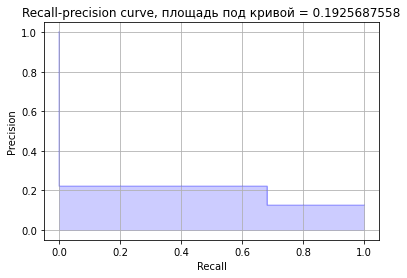

In [91]:
recall_precision_plot(y_test, y_pred_cv)

Обучим модель на всем датасете

In [92]:
lgr_cv.fit(X_new, Y)
y_pred_cv = lgr_cv.predict(test_new)
probs_cv = lgr_cv.predict_proba(test_new)
probs_cv = probs_cv[:,1]

In [93]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs_cv})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
73799,74835,0.214445
73800,17527,0.759907
73801,75683,0.309668
73802,26883,0.409065
73803,28862,0.141115
...,...,...
110143,83775,0.783766
110144,106254,0.092117
110145,81852,0.800135
110146,1971,0.606611


Вывод: за счет балансировки модели, а также исключени малозначительных признаков удалось значительно улучшить метрики модели.